# Implementation

## Code repo
https://github.com/KimDinh/CPSC-532W-2021W1/tree/master/a5

## Primitives
```python
def vector(addr, *args):
    if len(args) == 0:
        return torch.Tensor([])
    try:
        return torch.stack(list(args))
    except:
        return list(args)

def hashmap(addr, *args):
    e = list(args)
    keys = [e_.item() if isinstance(e_, torch.Tensor) else e_ for e_ in e[0::2]]
    return dict(zip(keys, e[1::2]))

def get(addr, e1, e2):
    if isinstance(e1, dict):
        return e1[e2.item() if isinstance(e2, torch.Tensor) else e2]
    else:
        return e1[int(e2)]

def put(addr, e1, e2, e3):
    ret = copy.deepcopy(e1)
    if isinstance(ret, dict):
        ret[e2.item() if isinstance(e2, torch.Tensor) else e2] = e3
    else:
        ret[int(e2)] = e3
    return ret

def append(addr, e1, e2):
    ret = copy.deepcopy(e1)
    if isinstance(ret, torch.Tensor):
        ret = torch.cat([ret, e2.unsqueeze(dim=0)])
    else:
        ret.append(e2)
    return ret

def cons(addr, e1, e2):
    ret = copy.deepcopy(e1)
    if isinstance(ret, torch.Tensor):
        ret = torch.cat([e2.unsqueeze(dim=0), ret])
    else:
        ret.insert(0, e2)
    return ret

def empty(addr, e):
    if isinstance(e, torch.Tensor):
        return e.size()[0] == 0
    else:
        return len(e) == 0

env = {
    'normal': Normal,
    'uniform-continuous': lambda addr, e1, e2: torch.distributions.Uniform(e1, e2),
    'beta': lambda addr, e1, e2: torch.distributions.Beta(e1, e2),
    'exponential': lambda addr, e: torch.distributions.Exponential(e),
    'discrete': lambda addr, e: torch.distributions.Categorical(e),
    'gamma': lambda addr, e1, e2: torch.distributions.Gamma(e1, e2),
    'dirichlet': lambda addr, e: torch.distributions.Dirichlet(e),
    'flip': lambda addr, e: torch.distributions.Bernoulli(e),
    'push-address' : push_addr,
    '+': lambda addr, e1, e2: e1 + e2,
    '-': lambda addr, e1, e2: e1 - e2,
    '*': lambda addr, e1, e2: e1 * e2,
    '/': lambda addr, e1, e2: e1 / e2,
    'sqrt': lambda addr, e: torch.sqrt(e),
    'exp': lambda addr, e: torch.exp(e),
    'log': lambda addr, e: torch.log(e),
    'abs': lambda addr, e: torch.abs(e),
    '>': lambda addr, e1, e2: e1 > e2,
    '<': lambda addr, e1, e2: e1 < e2,
    '>=': lambda addr, e1, e2: e1 >= e2,
    '<=': lambda addr, e1, e2: e1 <= e2,
    '=': lambda addr, e1, e2: e1 == e2,
    'and': lambda addr, e1, e2: e1 and e2,
    'or': lambda addr, e1, e2: e1 or e2,
    'vector': vector,
    'hash-map': hashmap,
    'get': get,
    'first': lambda addr, e: get(addr, e, 0),
    'second': lambda addr, e: get(addr, e, 1),
    'last': lambda addr, e: get(addr, e, -1),
    'rest': lambda addr, e: e[1:],
    'peek': lambda addr, e: get(addr, e, -1),
    'append': append,
    'put': put,
    'conj': append,
    'cons': cons,
    'empty?': empty
}
```

## Evaluator
```python
class Env(dict):
    """
    Copied from https://norvig.com/lispy.html and modified
    """
    def __init__(self, parms=(), args=(), outer=None):
        self.update(zip(parms, args))
        self.outer = outer

    def get(self, var):
        return self[var] if (var in self) else self.outer.get(var)


class Procedure(object):
    """
    Copied from https://norvig.com/lispy.html
    """
    def __init__(self, parms, body, env):
        self.parms, self.body, self.env = parms, body, env
    
    def __call__(self, *args, sigma): 
        return eval(self.body, sigma, Env(self.parms, args, self.env))


def evaluate(exp):
    func, sigma = eval(exp)
    ret, sigma = func(sigma=sigma)
    return ret


def eval(e, sigma={}, env=None):

    if env is None:
        env = standard_env()

    if (not isinstance(e, list)):
        if isinstance(e, list):
            e = e[0]
        if isinstance(e, numbers.Number):
            return torch.tensor(float(e)), sigma
        elif isinstance(e, str):
            val = env.get(e)
            if val is not None:
                return val, sigma
            else:
                return e, sigma
        else:
            raise("Expression type unknown.", e) 
    else:
        op = e[0]
        args = e[1:]
        if op == 'if':
            pred, sigma = eval(args[0], sigma, env)
            if pred:
                return eval(args[1], sigma, env)
            else:
                return eval(args[2], sigma, env)
        elif op == 'fn':
            params, body = args
            return Procedure(params, body, env), sigma
        elif op == 'sample':
            # evaluate push-address
            _, sigma = eval(args[0], sigma, env)
            # evaluate distribution and sample
            d, sigma = eval(args[1], sigma, env)
            return d.sample(), sigma
        elif op == 'observe':
            # evaluate push-address
            _, sigma = eval(args[0], sigma, env)
            # evaluate distribution and observed value
            d, sigma = eval(args[1], sigma, env)
            c, sigma = eval(args[2], sigma, env)
            return c, sigma
        else:
            func, sigma = eval(op, sigma, env)
            vals = []
            for arg in args:
                c, sigma = eval(arg, sigma, env)
                vals.append(c)
            if isinstance(func, Procedure):
                return func(*vals, sigma=sigma)
            else:
                return func(*vals), sigma
```

## Test Outputs
```
FOPPL Tests passed
FOPPL Tests passed
FOPPL Tests passed
FOPPL Tests passed
FOPPL Tests passed
FOPPL Tests passed
FOPPL Tests passed
FOPPL Tests passed
FOPPL Tests passed
FOPPL Tests passed
FOPPL Tests passed
FOPPL Tests passed
FOPPL Tests passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
Test passed
All deterministic tests passed
('normal', 5, 1.4142136)
p value 0.8644174822780564
('beta', 2.0, 5.0)
p value 0.3769172291770422
('exponential', 0.0, 5.0)
p value 0.270546249417139
('normal', 5.3, 3.2)
p value 0.8754333482446656
('normalmix', 0.1, -1, 0.3, 0.9, 1, 0.3)
p value 0.5873084911482642
('normal', 0, 1.44)
p value 0.17265323835383373
All probabilistic tests passed
```

#

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import sys
from daphne import daphne
from evaluator import evaluate

def load_exp(num):
    return daphne(['desugar-hoppl', '-i', '../a5/programs/{}.daphne'.format(num)])

# Program 1

In [2]:
sys.setrecursionlimit(8000)

exp = load_exp(1)
num_samples = int(2e5)
samples = []

start = time.time()
for i in range(num_samples):
    samples.append(evaluate(exp).item())
end = time.time()

print("Number of samples: {}".format(num_samples))
print("Sampling time: {} seconds".format(int(end-start)))
print("Prior mean: {:.3f}".format(np.mean(samples)))
print("Prior variance: {:.3f}".format(np.var(samples)))

Number of samples: 200000
Sampling time: 966 seconds
Prior mean: 99.309
Prior variance: 9979.104


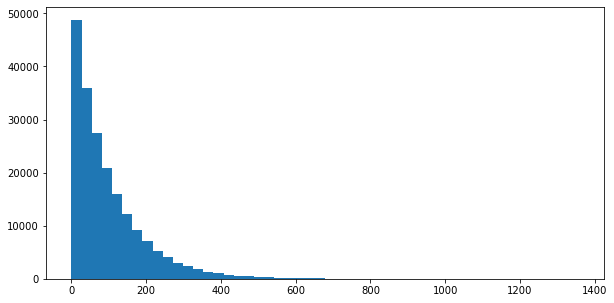

In [3]:
plt.figure(figsize=(10,5))
plt.hist(samples, bins=50)
plt.savefig("figs/p1_hist.png")

# Program 2

In [12]:
exp = load_exp(2)
num_samples = int(1e6)
samples = []

start = time.time()
for i in range(num_samples):
    samples.append(evaluate(exp).item())
end = time.time()

print("Number of samples: {}".format(num_samples))
print("Sampling time: {} seconds".format(int(end-start)))
print("Prior mean of mu: {:.3f}".format(np.mean(samples)))
print("Prior variance of mu: {:.3f}".format(np.var(samples)))

Number of samples: 1000000
Sampling time: 295 seconds
Prior mean of mu: 0.999
Prior variance of mu: 5.003


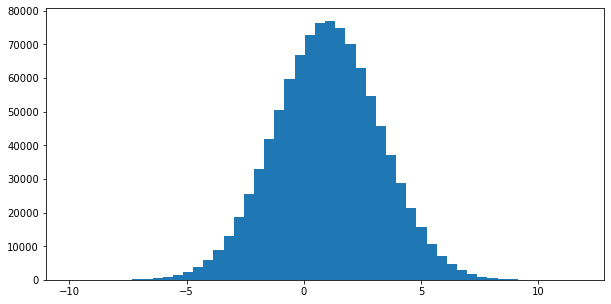

In [13]:
plt.figure(figsize=(10,5))
plt.hist(samples, bins=50)
plt.savefig("figs/p2_hist.png")

# Program 3

In [4]:
exp = load_exp(3)
num_samples = int(3e5)
samples = []

start = time.time()
for i in range(num_samples):
    samples.append(evaluate(exp).numpy().tolist())
end = time.time()
samples = np.array(samples)

print("Number of samples: {}".format(num_samples))
print("Sampling time: {} seconds".format(int(end-start)))
np.set_printoptions(threshold=np.inf, formatter={'float_kind': "{:.4f}".format})
print("Prior mean of each time step:\n", np.mean(samples, axis=0, keepdims=False))
print("Prior variance of each time step:\n", np.var(samples, axis=0, keepdims=False))

Number of samples: 300000
Sampling time: 625 seconds
Prior mean of each time step:
 [0.9993 1.4170 1.4704 1.4763 1.4785 1.4793 1.4804 1.4826 1.4781 1.4812
 1.4812 1.4765 1.4793 1.4811 1.4802 1.4807 1.4795]
Prior variance of each time step:
 [0.6668 0.5425 0.5625 0.5570 0.5560 0.5561 0.5541 0.5536 0.5577 0.5540
 0.5538 0.5604 0.5549 0.5556 0.5556 0.5558 0.5548]


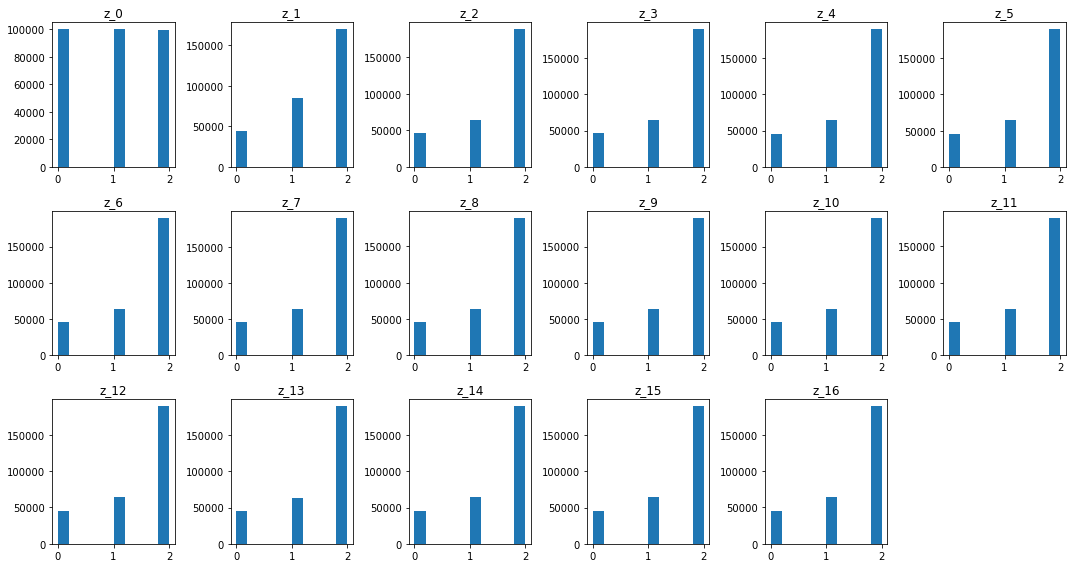

In [5]:
plt.figure(figsize=(15, 8))
for i in range(17):
    plt.subplot(3, 6, i+1)
    plt.hist(samples[:, i])
    plt.title("z_{}".format(i))
plt.tight_layout()
plt.savefig("figs/p3_hist.png")